In [1]:
import os
import spacy
import stanza
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import langid

/home/zia/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# Charger les modèles SpaCy pour les langues prises en charge
def load_spacy_models():
    spacy_models = {}
    supported_languages = ['de', 'en', 'fr', 'es', 'ja', 'pt', 'ru', 'ko', 'zh']
    for lang in supported_languages:
        try:
            spacy_models[lang] = spacy.load(f"{lang}_core_web_sm")
        except OSError:
            try:
                spacy_models[lang] = spacy.load(f"{lang}_core_news_sm")
            except OSError:
                print(f"No compatible package found for '{lang}'")
    return spacy_models

# Charger les modèles Stanza pour les langues non prises en charge par SpaCy
def load_stanza_models():
    stanza_models = {}
    for lang in ['ar', 'tr', 'vi','it']:
        stanza_models[lang] = stanza.Pipeline(lang=lang)
    return stanza_models

In [3]:
# Tokenisation du texte en fonction de la langue
def tokenize(lang, text, spacy_models, stanza_models):
    if lang in stanza_models:
        nlp = stanza_models[lang]
        doc = nlp(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = spacy_models[lang]
        doc = nlp(text)
        return [token.text for token in doc]

In [4]:
# Charger les modèles SpaCy et Stanza
spacy_models = load_spacy_models()
stanza_models = load_stanza_models()

2024-05-12 17:09:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-12 17:09:39 INFO: Downloaded file to /home/zia/stanza_resources/resources.json
2024-05-12 17:09:40 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-12 17:09:40 INFO: Using device: cpu
2024-05-12 17:09:40 INFO: Loading: tokenize
2024-05-12 17:09:41 INFO: Loading: mwt
2024-05-12 17:09:41 INFO: Loading: pos
2024-05-12 17:09:41 INFO: Loading: lemma
2024-05-12 17:09:41 INFO: Loading: depparse
2024-05-12 17:09:41 INFO: Loading: ner
2024-05-12 17:09:42 INFO: Done loading processors!
2024-05-12 17:09:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-12 17:09:42 INFO: Downloaded file to /home/zia/stanza_resources/resources.json
2024-05-12 17:09:44 INFO: Loading these models for language: tr (Turkish):
| Processor | Package       |
-----------------------------
| tokenize  | imst          |
| mwt       | imst          |
| pos       | imst_charlm   |
| lemma     | imst_nocharlm |
| depparse  | imst_charlm   |
| ner       | starlang      |

2024-05-12 17:09:44 INFO: Using device: cpu
2024-05-12 17:09:44 INFO: Loading: tokenize
2024-05-12 17:09:44 INFO: Loading: mwt
2024-05-12 17:09:44 INFO: Loading: pos
2024-05-12 17:09:44 INFO: Loading: lemma
2024-05-12 17:09:44 INFO: Loading: depparse
2024-05-12 17:09:44 INFO: Loading: ner
2024-05-12 17:09:45 INFO: Done loading processors!
2024-05-12 17:09:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-12 17:09:45 INFO: Downloaded file to /home/zia/stanza_resources/resources.json
2024-05-12 17:09:47 INFO: Loading these models for language: vi (Vietnamese):
| Processor    | Package       |
--------------------------------
| tokenize     | vtb           |
| pos          | vtb_charlm    |
| lemma        | identity      |
| constituency | vlsp22_charlm |
| depparse     | vtb_charlm    |
| sentiment    | vsfc_charlm   |
| ner          | vlsp          |

2024-05-12 17:09:47 INFO: Using device: cpu
2024-05-12 17:09:47 INFO: Loading: tokenize
2024-05-12 17:09:47 INFO: Loading: pos
2024-05-12 17:09:47 INFO: Loading: lemma
2024-05-12 17:09:47 INFO: Loading: constituency
2024-05-12 17:09:48 INFO: Loading: depparse
2024-05-12 17:09:48 INFO: Loading: sentiment
2024-05-12 17:09:48 INFO: Loading: ner
2024-05-12 17:09:49 INFO: Done loading processors!
2024-05-12 17:09:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with

2024-05-12 17:09:49 INFO: Downloaded file to /home/zia/stanza_resources/resources.json
2024-05-12 17:09:51 INFO: Loading these models for language: it (Italian):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | vit_charlm        |
| depparse     | combined_charlm   |
| ner          | fbk               |

2024-05-12 17:09:51 INFO: Using device: cpu
2024-05-12 17:09:51 INFO: Loading: tokenize
2024-05-12 17:09:51 INFO: Loading: mwt
2024-05-12 17:09:51 INFO: Loading: pos
2024-05-12 17:09:51 INFO: Loading: lemma
2024-05-12 17:09:51 INFO: Loading: constituency
2024-05-12 17:09:52 INFO: Loading: depparse
2024-05-12 17:09:52 INFO: Loading: ner
2024-05-12 17:09:53 INFO: Done loading processors!


In [6]:

# Calculer la diversité lexicale
def lexical_diversity_metrics(data):
    results = {}
    for _, row in data.iterrows():
        tokens = tokenize(row["labels"], row["text"], spacy_models, stanza_models)
        total_words = sum(map(len, tokens))
        unique_words = len(set(word for token in tokens for word in token))
        average_words_per_sample = total_words / len(tokens) if tokens else 0
        lexical_diversity = unique_words / total_words if total_words else 0
        results[row["labels"]] = {
            "Total Words": total_words,
            "Unique Words": unique_words,
            "Average Words per Sample": average_words_per_sample,
            "Lexical Diversity": lexical_diversity
        }
    return pd.DataFrame(results).T


In [ ]:
# Calculer les statistiques sur les données
def calculate_stats(data, spacy_models, stanza_models):
    languages = defaultdict(int)
    tokens = defaultdict(int)
    text_lengths = defaultdict(list)

    for _, row in data.iterrows():
        lang = row["labels"]
        text = row["text"]
        languages[lang] += 1
        tokens[lang] += len(tokenize(lang, text, spacy_models, stanza_models))
        text_lengths[lang].append(len(text))

    stats = {
        "n_lang": len(languages),
        "n_text": sum(languages.values()),
        "n_text_per_lang": languages,
        "mean_tokens_per_text": {lang: tokens[lang] / languages[lang] for lang in languages},
        "mean_text_length_per_lang": {lang: sum(text_lengths[lang]) / languages[lang] for lang in languages}
    }

    df_stats = pd.DataFrame(stats).T
    df_stats["Global"] = df_stats.sum(axis=1)
    return df_stats

In [22]:

# Calculer la loi de Zipf pour chaque langue
def zipf_law_by_lang(data):
    results = []

    for text, lang in zip(data["text"], data["labels"]):
        lang = langid.classify(text)[0] if lang == "unknown" else lang
        tokens = tokenize(lang, text, spacy_models, stanza_models)
        freq = pd.Series(tokens).value_counts()
        freq = freq.reset_index()
        freq.columns = ["Token", "Frequency"]
        freq["Rank"] = freq["Frequency"].rank(ascending=False)
        freq["Language"] = lang
        results.append(freq)

    final_df = pd.concat(results)
    final_df["Frequency"] = final_df["Frequency"] / final_df["Frequency"].sum()
    return final_df[["Token", "Frequency", "Rank", "Language"]]

# Tracer la loi de Zipf pour chaque langue
def save_zipf_plots(data, output_dir):
    sns.set(style="whitegrid")
    g = sns.FacetGrid(data, col="Language", col_wrap=3, sharex=False, sharey=False)
    for lang, ax in g.axes_dict.items():
        lang_data = data[data["Language"] == lang]
        sns.lineplot(data=lang_data, x="Rank", y="Frequency", ax=ax)
        ax.set_title(f"Zipf's Law - {lang}")
        ax.set_xlabel("Rank")
        ax.set_ylabel("Frequency")
    g.savefig(output_dir)  # Enregistrer le FacetGrid dans un seul fichier PNG

In [8]:

# Calculer la longueur moyenne des phrases par langue
def average_sentence_length(data):
    avg_lengths = {}
    for lang, group in data.groupby("labels"):
        total_sentences = sum(text.count(".") for text in group["text"])
        total_words = sum(len(text.split()) for text in group["text"])
        avg_lengths[lang] = total_words / total_sentences if total_sentences > 0 else 0
    return avg_lengths

# Calculer la distribution des longueurs de texte par langue
def text_length_distribution(data):
    length_distribution = {}
    for lang, group in data.groupby("labels"):
        lengths = [len(text) for text in group["text"]]
        length_distribution[lang] = lengths
    return length_distribution

In [9]:
# Vérifier et créer les répertoires s'ils n'existent pas
resultats_dirs = ["./results/CSV", "./results/IMAGES"]
for directory in resultats_dirs:
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        print(f"Le répertoire '{directory}' existe déjà.")

# Charger les données
data = pd.read_csv("../data/clean/results/CSV/result.csv")
print("Les données ont été chargées avec succès.")

Les données ont été chargées avec succès.


In [10]:
# Enregistrer les statistiques
stats_file = "./results/CSV/statisques.csv"
stats = calculate_stats(data, spacy_models, stanza_models)
print(stats)  # Affichage des statistiques
stats.to_csv(stats_file)
print(f"Les statistiques ont été calculées et enregistrées dans '{stats_file}'.")

                                   pt          fr          it          vi  \
n_lang                      13.000000   13.000000   13.000000   13.000000   
n_text                     614.000000  614.000000  614.000000  614.000000   
n_text_per_lang             47.000000   33.000000   23.000000   79.000000   
mean_tokens_per_text        16.723404   21.151515   21.521739   13.721519   
mean_text_length_per_lang   86.276596  111.030303  112.130435   74.569620   

                                   ko      ar       es          ja  \
n_lang                      13.000000   13.00   13.000   13.000000   
n_text                     614.000000  614.00  614.000  614.000000   
n_text_per_lang             69.000000   20.00   40.000   48.000000   
mean_tokens_per_text        11.478261   33.65   19.900   17.416667   
mean_text_length_per_lang   40.942029  156.60  107.375   33.708333   

                                   de        ru          zh          en  \
n_lang                      13.000000   1

In [11]:
# Enregistrer la diversité lexicale
metrics_file = "./results/CSV/diversite_lexicale.csv"
metrics = lexical_diversity_metrics(data)
print(metrics)  # Affichage des statistiques
metrics.to_csv(metrics_file)
print(f"Les métriques ont été calculées et enregistrées dans '{metrics_file}'.")

    Total Words  Unique Words  Average Words per Sample  Lexical Diversity
pt         51.0          21.0                  3.923077           0.411765
fr        126.0          31.0                  4.666667           0.246032
it        115.0          32.0                  3.484848           0.278261
vi         45.0          29.0                  4.500000           0.644444
ko         12.0          11.0                  4.000000           0.916667
ar        159.0          29.0                  3.975000           0.182390
es         31.0          19.0                  4.428571           0.612903
ja         27.0          26.0                  2.454545           0.962963
de         35.0          18.0                  4.375000           0.514286
ru        256.0          46.0                  4.266667           0.179688
zh        100.0          73.0                  1.851852           0.730000
en         27.0          15.0                  4.500000           0.555556
tr        163.0          

Les lois de Zipf ont été calculées et affichées avec succès avant d'être enregistrées dans un seul fichier PNG.


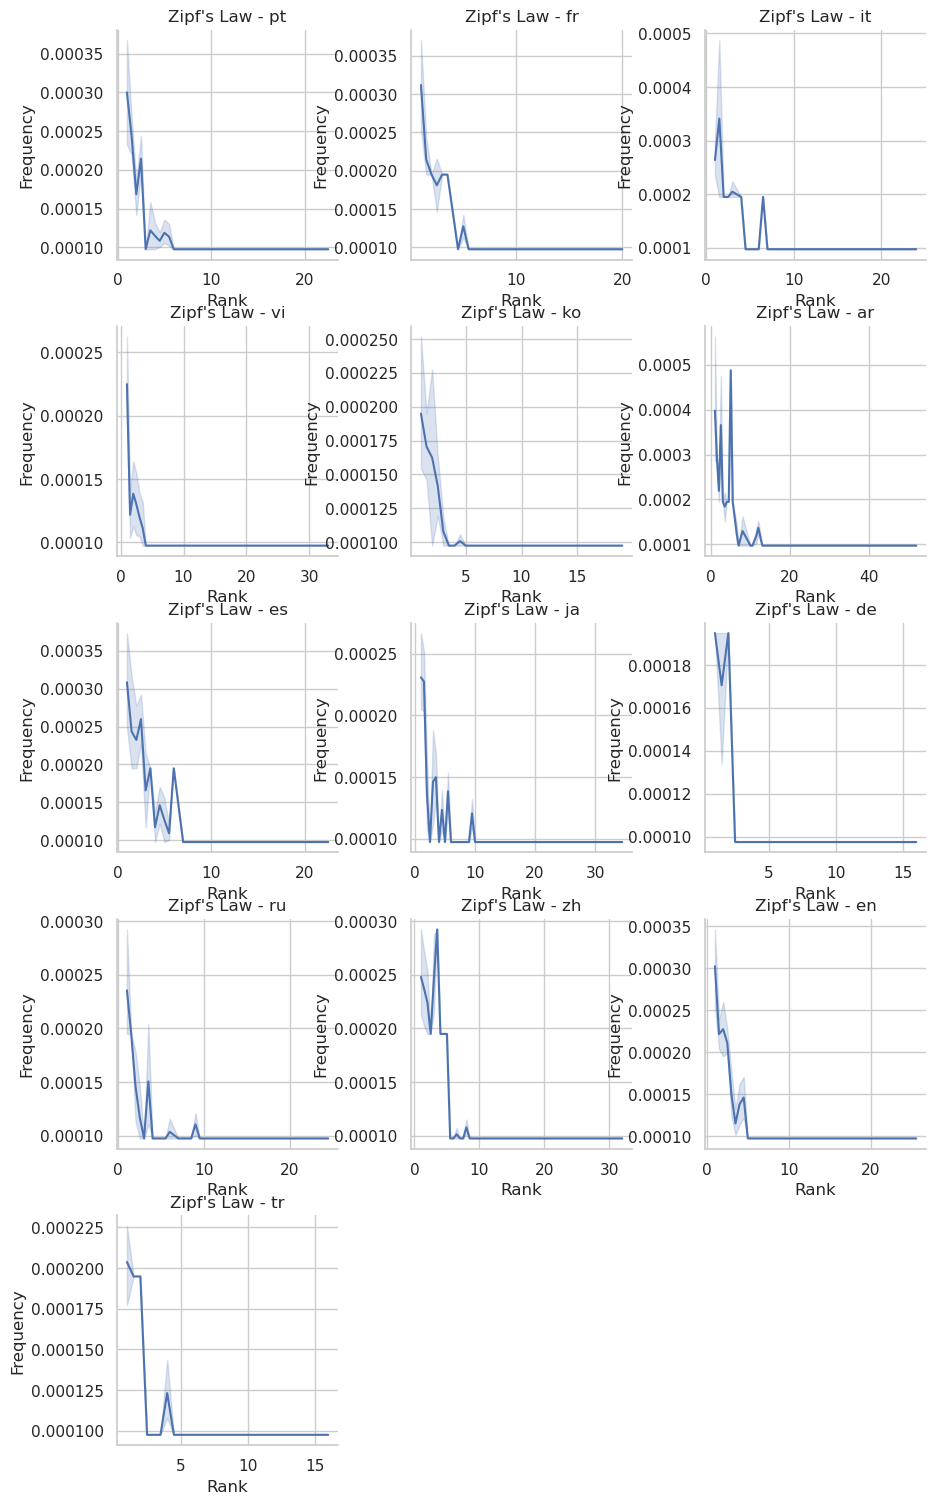

In [23]:
# Utilisation de la fonction pour tracer la loi de Zipf et enregistrer les graphiques dans un seul fichier PNG

output_dir = "./results/IMAGES/zipf.png"
zipf_results = zipf_law_by_lang(data)
save_zipf_plots(zipf_results, output_dir)

# Affichage des résultats
print("Les lois de Zipf ont été calculées et affichées avec succès avant d'être enregistrées dans un seul fichier PNG.")

In [13]:

# Calculer et sauvegarder la longueur moyenne des phrases par langue
avg_sentence_lengths = average_sentence_length(data)
avg_sentence_lengths_df = pd.DataFrame(avg_sentence_lengths.items(), columns=["Language", "Average Sentence Length"])
print(avg_sentence_lengths_df)  # Affichage des longueurs moyennes des phrases
avg_sentence_lengths_df.to_csv("./results/CSV/avg_sentence_lengths.csv", index=False)
print("La longueur moyenne des phrases par langue a été calculée et enregistrée avec succès.")

   Language  Average Sentence Length
0        ar                16.944444
1        de                11.931818
2        en                15.666667
3        es                17.390244
4        fr                18.870968
5        it                14.615385
6        ja                34.500000
7        ko                10.175439
8        pt                11.677966
9        ru                11.204082
10       tr                11.322581
11       vi                21.862069
12       zh                50.000000
La longueur moyenne des phrases par langue a été calculée et enregistrée avec succès.


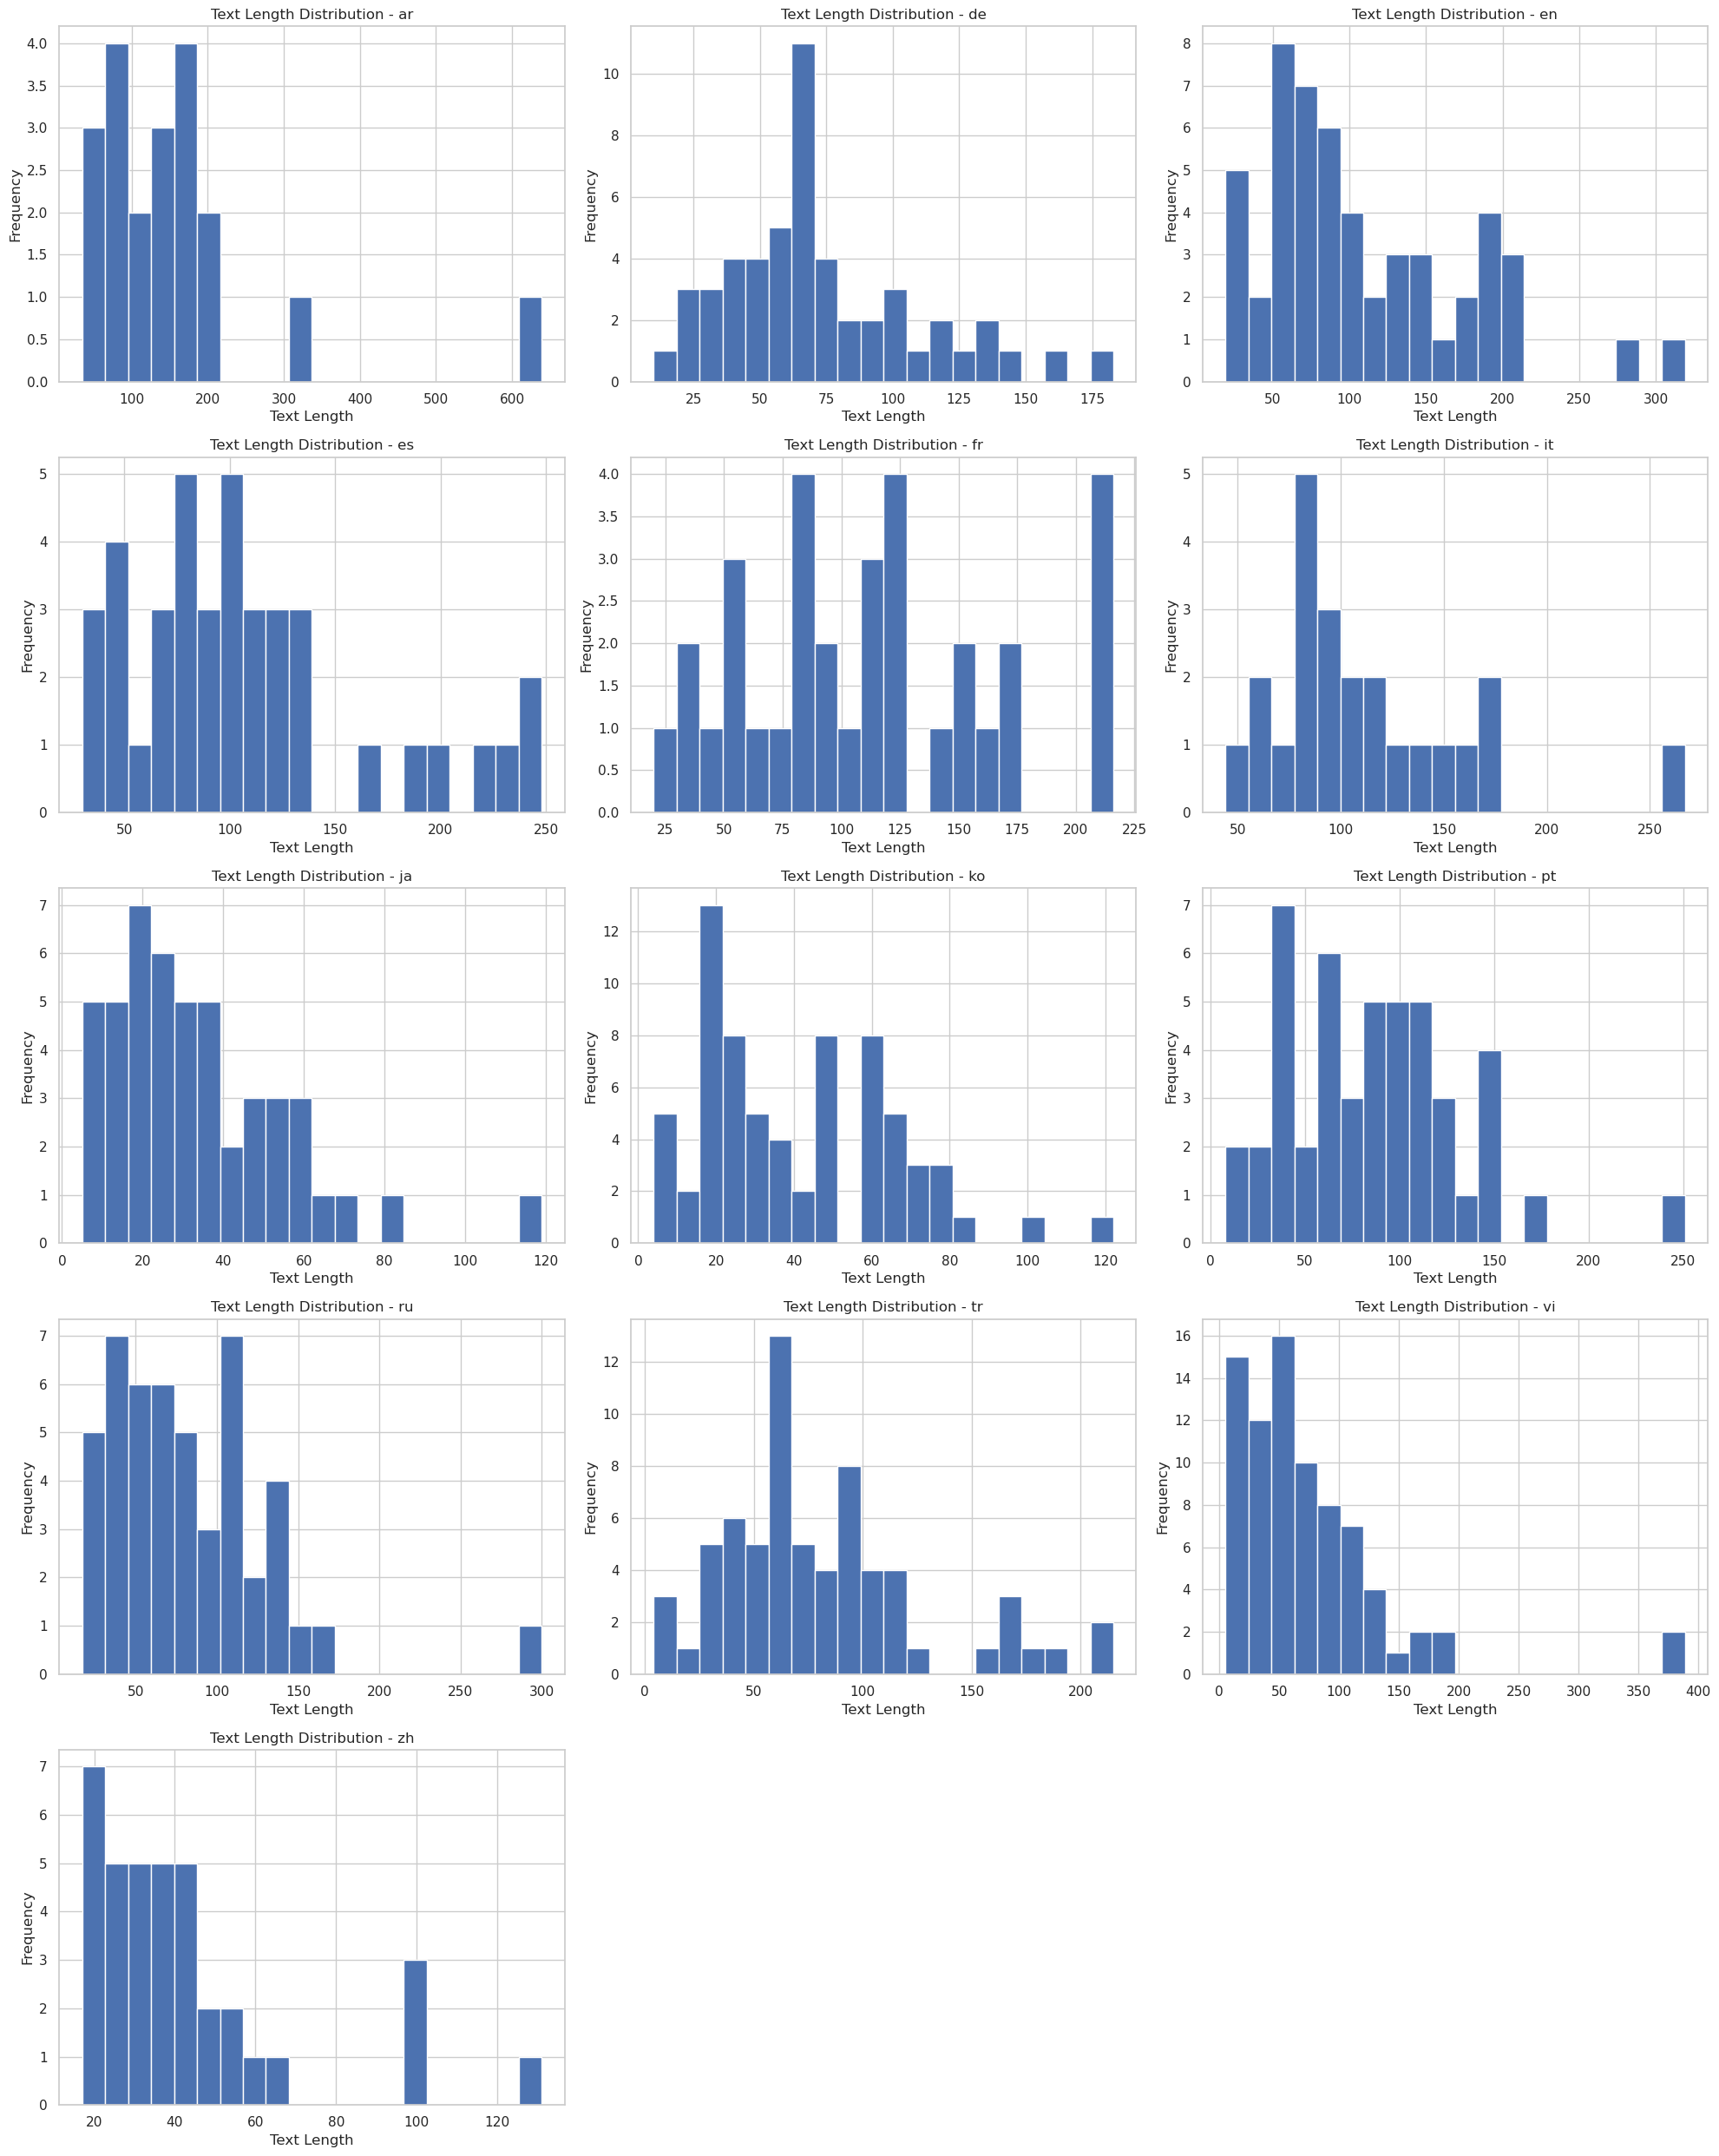

Les distributions des longueurs de texte par langue ont été combinées et enregistrées dans './results/IMAGES/text_length_distributions_combined.png'.


In [14]:
# Calculer la distribution des longueurs de texte par langue
length_distributions = text_length_distribution(data)

# Créer une grille de sous-graphiques avec 4 graphiques par rangée
num_rows = (len(length_distributions) + 2) // 3  # Calculer le nombre de rangées nécessaire
fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))  # Créer la grille de sous-graphiques

# Afficher et sauvegarder la distribution des longueurs de texte par langue dans les sous-graphiques
for i, (lang, lengths) in enumerate(length_distributions.items()):
    row = i // 3  # Récupérer le numéro de rangée
    col = i % 3   # Récupérer le numéro de colonne
    ax = axes[row, col]  # Sélectionner le sous-graphique correspondant
    ax.hist(lengths, bins=20)
    ax.set_xlabel("Text Length")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Text Length Distribution - {lang}")

# Supprimer les sous-graphiques vides
for i in range(len(length_distributions), num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

# Ajuster l'espacement entre les sous-graphiques pour éviter les chevauchements
plt.tight_layout()

# Enregistrer le fichier PNG contenant tous les graphiques
output_file = "./results/IMAGES/text_length_distributions_combined.png"
plt.savefig(output_file, facecolor="white", dpi=300)
plt.show()

print(f"Les distributions des longueurs de texte par langue ont été combinées et enregistrées dans '{output_file}'.")


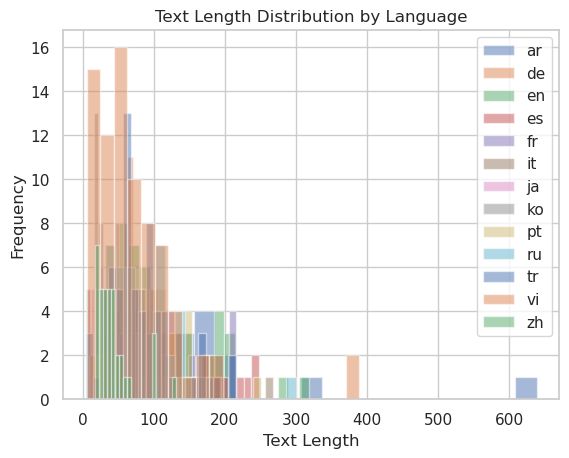

La distribution des longueurs de texte par langue a été calculée et enregistrée avec succès.


In [15]:
# Afficher et sauvegarder la distribution des longueurs de texte par langue
for lang, lengths in length_distributions.items():
    plt.hist(lengths, bins=20, alpha=0.5, label=lang)

plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution by Language")
plt.legend()
plt.savefig("./results/IMAGES/general_length.png", facecolor="white", dpi=300)
plt.show()

print("La distribution des longueurs de texte par langue a été calculée et enregistrée avec succès.")